In [1]:
from itertools import count
from typing import Callable, Any

from record_preprocess import *

In [2]:
LOAD_UTIL_CONFIG.LOAD_UTIL = True
load_all_play_records()

/Users/purchaser/PycharmProjects/MMKP-solver/data_source.py:58: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  self.most_memory_consumption: int = stats.mode(memories)[0][0]


Data sources loaded
json file: /Users/purchaser/PycharmProjects/MMKP-solver/plots/datas/reports/Player_trace_cluster_64_data_source_phi_static_MMKP_no_spread_2023-03-14-15-21-31/json loaded
json file: /Users/purchaser/PycharmProjects/MMKP-solver/plots/datas/reports/Player_trace_cluster_64_data_source_ali_static_Tiresias_2023-03-14-16-32-08/json loaded
json file: /Users/purchaser/PycharmProjects/MMKP-solver/plots/datas/reports/Player_trace_cluster_64_data_source_phi_trace_MMKP_RR_partition_2023-03-14-12-33-32/json loaded
json file: /Users/purchaser/PycharmProjects/MMKP-solver/plots/datas/reports/Player_trace_cluster_8_data_source_phi_static_KubeShare_2023-03-15-17-39-52/json loaded
json file: /Users/purchaser/PycharmProjects/MMKP-solver/plots/datas/reports/Player_trace_cluster_8R_data_source_phi_static_Tiresias_2023-03-15-17-40-04/json loaded
json file: /Users/purchaser/PycharmProjects/MMKP-solver/plots/datas/reports/Player_trace_cluster_8_data_source_phi_static_Kubernetes_2023-03-15-17

In [3]:

def get_time_series_func(extract_item: Callable[[AssignmentStatistics], Any],
                         scheduler_to_record: Dict[SchedulerName, PlayRecord], time_interval=60):
    scheduler_to_items = defaultdict(list)
    scheduler_to_curr_record_idx = defaultdict(int)
    time_interval *= 1e9
    time_interval = int(time_interval)
    for i in count(0):
        now = i * time_interval
        has_none_zero = False
        for scheduler, record in scheduler_to_record.items():
            idx = scheduler_to_curr_record_idx[scheduler]
            while idx + 1 < len(record.assignment_statistics) and record.assignment_statistics[idx + 1].now < now:
                idx += 1
            if idx >= len(record.assignment_statistics) - 1:
                # break
                # scheduler_to_items[scheduler].append(0)
                continue
            has_none_zero = True
            scheduler_to_curr_record_idx[scheduler] = idx
            assignment_stats = record.assignment_statistics[idx]
            item = extract_item(assignment_stats)
            scheduler_to_items[scheduler].append(item)
        if not has_none_zero:
            break
    return scheduler_to_items


def time_series_profit(scheduler_to_record: Dict[SchedulerName, PlayRecord], time_interval=60):
    return get_time_series_func(lambda assignment_stats: assignment_stats.profit, scheduler_to_record,
                                time_interval)


def time_series_comp_util(scheduler_to_record: Dict[SchedulerName, PlayRecord], time_interval=60):
    return get_time_series_func(lambda assignment_stats: assignment_stats.total_comp_util, scheduler_to_record,
                                time_interval)


def time_series_mem_util(scheduler_to_record: Dict[SchedulerName, PlayRecord], time_interval=60):
    return get_time_series_func(lambda assignment_stats: assignment_stats.total_mem_utilization, scheduler_to_record,
                                time_interval)


def time_series_deployed_count(scheduler_to_record: Dict[SchedulerName, PlayRecord], time_interval=60):
    return get_time_series_func(lambda assignment_stats: assignment_stats.deployed_job_size, scheduler_to_record,
                                time_interval)


def plot_avg_time_series_profit_bar():
    original_fontsize = mpl.rcParams["font.size"]
    mpl.rcParams.update({'font.size': 24})
    schedulers = [SchedulerName.SPREAD,
                  SchedulerName.KubeShare,
                  SchedulerName.Gavel,
                  SchedulerName.Tiresias,
                  SchedulerName.Kubernetes,
                  SchedulerName.AFS,
                  SchedulerName.SPREAD_PRIME]
    fig, ax = plt.subplots(figsize=(16, 4))
    data_source_names = [
        DataSourceName.DataSourceAliDyn,
        DataSourceName.DataSourceAliSta,
        DataSourceName.DataSourcePhiDyn,
        DataSourceName.DataSourcePhiSta,
    ]
    X = np.arange(len(data_source_names))
    width = 0.1
    schedulers_to_avg_profits = defaultdict(list)
    for i, data_source_name in enumerate(data_source_names):
        scheduler_to_record = dict()
        for scheduler in schedulers:
            play_record = extract_play_record(mode=SessionMode.Trace,
                                              data_source_name=data_source_name,
                                              cluster_name=ClusterName.Cluster64,
                                              scheduler_name=scheduler)
            assert len(play_record) == 1
            play_record = play_record[0]
            scheduler_to_record[scheduler] = play_record
        scheduler_to_profits = time_series_profit(scheduler_to_record)
        for scheduler in schedulers:
            profits = scheduler_to_profits[scheduler]
            profits = list(filter(lambda profit: profit > 64, profits))
            schedulers_to_avg_profits[scheduler].append(np.mean(profits))

    hatch = "/"
    for i, scheduler in enumerate(schedulers):
        avg_profits = schedulers_to_avg_profits[scheduler]
        spec = scheduler_to_spec(scheduler_name=scheduler)
        print(f"{scheduler}: ", np.array(avg_profits))
        ax.bar(
            X + i * width,
            np.array(avg_profits),
            # edgecolor=edgecolor,
            width=width,
            color=spec["color"],
            label=spec["label"],
            hatch=hatch
        )
    ax.set_xticks(X + (width / 2) * (len(schedulers) - 1),
                  [data_source_to_spec(data_source_name=dn)["label"] for dn in data_source_names])
    # ax.yaxis.set_major_formatter(plt_ticker.FuncFormatter('{0:.0%}'.format))
    y_major_loc = plt_ticker.MultipleLocator(base=30)
    ax.yaxis.set_major_locator(y_major_loc)
    fig.tight_layout()
    fig.legend(loc=(0.1, 0.68), ncol=4)
    fig.subplots_adjust(top=0.6)
    ax.set_ylabel('Avg. $\hat{T}$')
    ax.set_xlabel('Workloads')
    ax.yaxis.grid(True)
    save_fig(fig, output_path(f"avg_profit_bar.pdf"))
    mpl.rcParams.update({'font.size': original_fontsize})


def plot_makespan_bar():
    original_fontsize = mpl.rcParams["font.size"]
    mpl.rcParams.update({'font.size': 26})
    schedulers = [SchedulerName.SPREAD,
                  SchedulerName.KubeShare,
                  SchedulerName.Gavel,
                  SchedulerName.Tiresias,
                  SchedulerName.AFS,
                  SchedulerName.Kubernetes,
                  SchedulerName.SPREAD_PRIME]
    cluster_name = ClusterName.Cluster64
    fig, ax = plt.subplots(figsize=(16, 4))
    data_source_names = [
        DataSourceName.DataSourceAliSta,
        DataSourceName.DataSourcePhiSta,
    ]
    X = np.arange(len(data_source_names))
    width = 0.1
    schedulers_to_makespans = defaultdict(list)
    for i, data_source_name in enumerate(data_source_names):
        for scheduler in schedulers:
            play_record = extract_play_record(
                mode=SessionMode.Trace,
                data_source_name=data_source_name,
                cluster_name=cluster_name,
                scheduler_name=scheduler)
            assert len(play_record) == 1
            play_record = play_record[0]
            max_completion_time = np.max([done_job.completion_time for done_job in play_record.done_records.values()])
            schedulers_to_makespans[scheduler].append(max_completion_time)

    bottom = 0.75
    hatch = "/"
    for i, scheduler in enumerate(schedulers):
        base = schedulers_to_makespans[SchedulerName.SPREAD]
        makespans = schedulers_to_makespans[scheduler]
        makespans_normalized = np.array(makespans) / np.array(base)
        spec = scheduler_to_spec(scheduler_name=scheduler)
        print(f"{scheduler}: ", np.array(makespans_normalized))
        ax.bar(
            X + i * width,
            np.array(makespans_normalized) - bottom,
            width=width,
            color=spec["color"],
            label=spec["label"],
            hatch=hatch,
            bottom=bottom
        )
    ax.spines['bottom'].set_position(('data', bottom))
    ax.set_xticks(X + (width / 2) * (len(schedulers) - 1),
                  [data_source_to_spec(data_source_name=dn)["label"] for dn in data_source_names])
    ax.set_yticks([1, 1.25, 1.5, 1.75])
    fig.tight_layout()
    fig.legend(loc=(0.1, 0.68), ncol=4)
    fig.subplots_adjust(top=0.6)
    ax.set_ylabel('Norm. Makespan')
    ax.set_xlabel('Workloads')
    ax.yaxis.grid(True)
    ax.yaxis.set_major_formatter(plt_ticker.FuncFormatter('{0:.0%}'.format))
    save_fig(fig, output_path(f"makespan_bar.pdf"))
    mpl.rcParams.update({'font.size': original_fontsize})


def plot_JCT_bar():
    original_fontsize = mpl.rcParams["font.size"]
    mpl.rcParams.update({'font.size': 26})
    schedulers = [SchedulerName.SPREAD,
                  SchedulerName.KubeShare,
                  SchedulerName.Gavel,
                  SchedulerName.Tiresias,
                  SchedulerName.AFS,
                  # SchedulerName.Kubernetes,
                  SchedulerName.SPREAD_PRIME]
    fig, ax = plt.subplots(figsize=(16, 4))
    cluster_name = ClusterName.Cluster64
    data_source_names = [
        DataSourceName.DataSourceAliDyn,
        DataSourceName.DataSourceAliSta,
        DataSourceName.DataSourcePhiDyn,
        DataSourceName.DataSourcePhiSta,
    ]
    X = np.arange(len(data_source_names))
    width = 0.1
    schedulers_to_JCTs = defaultdict(list)
    for i, data_source_name in enumerate(data_source_names):
        for scheduler in schedulers:
            play_record = extract_play_record(
                mode=SessionMode.Trace,
                data_source_name=data_source_name,
                cluster_name=cluster_name,
                scheduler_name=scheduler)
            assert len(play_record) == 1
            play_record = play_record[0]
            JCTs = list()
            for done_job in play_record.done_records.values():
                JCT = done_job.completion_time - done_job.submit_time
                JCTs.append(JCT)
            avg_jct = np.mean(JCTs)
            schedulers_to_JCTs[scheduler].append(avg_jct)

    bottom = 0.75
    hatch = "/"
    for i, scheduler in enumerate(schedulers):
        base = schedulers_to_JCTs[SchedulerName.SPREAD]
        avgJCTs = schedulers_to_JCTs[scheduler]
        avgJCTs_normalized = np.array(avgJCTs) / np.array(base)
        spec = scheduler_to_spec(scheduler_name=scheduler)
        print(f"{scheduler}: ", np.array(avgJCTs_normalized))
        ax.bar(
            X + i * width,
            np.array(avgJCTs_normalized) - bottom,
            width=width,
            color=spec["color"],
            label=spec["label"],
            hatch=hatch,
            bottom=bottom
        )
    ax.spines['bottom'].set_position(('data', bottom))
    ax.set_xticks(X + (width / 2) * (len(schedulers) - 1),
                  [data_source_to_spec(data_source_name=dn)["label"] for dn in data_source_names])
    ax.set_yticks([1, 1.5, 2.0])
    fig.tight_layout()
    fig.legend(loc=(0.1, 0.68), ncol=3)
    fig.subplots_adjust(top=0.6)
    ax.set_ylabel('Norm. $JCT_{avg}$')
    ax.set_xlabel('Workloads')
    ax.yaxis.grid(True)
    ax.yaxis.set_major_formatter(plt_ticker.FuncFormatter('{0:.0%}'.format))
    save_fig(fig, output_path(f"JCT_bar.pdf"))
    mpl.rcParams.update({'font.size': original_fontsize})


def plot_JCT_and_makespan_bar():
    # original_fontsize = mpl.rcParams["font.size"]
    mpl.rcParams.update({'font.size': 26})
    fig, axes = plt.subplots(1, 2, figsize=(16, 5), gridspec_kw={'width_ratios': [2, 1]})

    def plot_JCT(ax):
        schedulers = [SchedulerName.SPREAD,
                      SchedulerName.KubeShare,
                      SchedulerName.Gavel,
                      SchedulerName.Tiresias,
                      SchedulerName.AFS,
                      # SchedulerName.Kubernetes,
                      SchedulerName.SPREAD_PRIME]
        cluster_name = ClusterName.Cluster64
        data_source_names = [
            DataSourceName.DataSourceAliDyn,
            DataSourceName.DataSourceAliSta,
            DataSourceName.DataSourcePhiDyn,
            DataSourceName.DataSourcePhiSta,
        ]
        X = np.arange(len(data_source_names))
        width = 0.1
        schedulers_to_JCTs = defaultdict(list)
        for i, data_source_name in enumerate(data_source_names):
            for scheduler in schedulers:
                play_record = extract_play_record(
                    mode=SessionMode.Trace,
                    data_source_name=data_source_name,
                    cluster_name=cluster_name,
                    scheduler_name=scheduler)
                assert len(play_record) == 1
                play_record = play_record[0]
                JCTs = list()
                for done_job in play_record.done_records.values():
                    JCT = done_job.completion_time - done_job.submit_time
                    JCTs.append(JCT)
                avg_jct = np.mean(JCTs)
                schedulers_to_JCTs[scheduler].append(avg_jct)

        bottom = 0.75
        hatch = "/"
        for i, scheduler in enumerate(schedulers):
            base = schedulers_to_JCTs[SchedulerName.SPREAD]
            avgJCTs = schedulers_to_JCTs[scheduler]
            avgJCTs_normalized = np.array(avgJCTs) / np.array(base)
            spec = scheduler_to_spec(scheduler_name=scheduler)
            print(f"{scheduler} avg JCT for each workloads: ", np.array(avgJCTs_normalized))
            ax.bar(
                X + i * width,
                np.array(avgJCTs_normalized) - bottom,
                width=width,
                color=spec["color"],
                label=spec["label"],
                hatch=hatch,
                bottom=bottom
            )
        ax.spines['bottom'].set_position(('data', bottom))
        ax.set_xticks(X + (width / 2) * (len(schedulers) - 1),
                      [data_source_to_spec(data_source_name=dn)["label"] for dn in data_source_names])
        ax.set_yticks([1, 1.5, 2.0])
        ax.set_ylabel('Norm. $JCT_{avg}$')
        ax.set_xlabel('Workloads')
        ax.yaxis.grid(True)
        ax.yaxis.set_major_formatter(plt_ticker.FuncFormatter('{0:.0%}'.format))

    def plot_makespan(ax):
        schedulers = [SchedulerName.SPREAD,
                      SchedulerName.KubeShare,
                      SchedulerName.Gavel,
                      SchedulerName.Tiresias,
                      SchedulerName.AFS,
                      SchedulerName.Kubernetes,
                      SchedulerName.SPREAD_PRIME]
        cluster_name = ClusterName.Cluster64
        data_source_names = [
            DataSourceName.DataSourceAliSta,
            DataSourceName.DataSourcePhiSta,
        ]
        X = np.arange(len(data_source_names))
        width = 0.1
        schedulers_to_makespans = defaultdict(list)
        for i, data_source_name in enumerate(data_source_names):
            for scheduler in schedulers:
                play_record = extract_play_record(
                    mode=SessionMode.Trace,
                    data_source_name=data_source_name,
                    cluster_name=cluster_name,
                    scheduler_name=scheduler)
                assert len(play_record) == 1
                play_record = play_record[0]
                max_completion_time = np.max(
                    [done_job.completion_time for done_job in play_record.done_records.values()])
                schedulers_to_makespans[scheduler].append(max_completion_time)

        bottom = 0.75
        hatch = "/"
        for i, scheduler in enumerate(schedulers):
            base = schedulers_to_makespans[SchedulerName.SPREAD]
            makespans = schedulers_to_makespans[scheduler]
            makespans_normalized = np.array(makespans) / np.array(base)
            spec = scheduler_to_spec(scheduler_name=scheduler)
            print(f"{scheduler} makespan for each workloads: ", np.array(makespans_normalized))
            ax.bar(
                X + i * width,
                np.array(makespans_normalized) - bottom,
                width=width,
                color=spec["color"],
                label=spec["label"],
                hatch=hatch,
                bottom=bottom
            )
        ax.spines['bottom'].set_position(('data', bottom))
        ax.set_xticks(X + (width / 2) * (len(schedulers) - 1),
                      [data_source_to_spec(data_source_name=dn)["label"] for dn in data_source_names])
        ax.set_yticks([1, 1.25, 1.5, 1.75])
        ax.set_ylabel('Norm. Makespan')
        ax.set_xlabel('Workloads')
        ax.yaxis.grid(True)
        ax.yaxis.set_major_formatter(plt_ticker.FuncFormatter('{0:.0%}'.format))

    plot_JCT(axes[0])
    plot_makespan(axes[1])
    fig.tight_layout()
    schedulers = [SchedulerName.SPREAD,
                  SchedulerName.KubeShare,
                  SchedulerName.Gavel,
                  SchedulerName.Tiresias,
                  SchedulerName.AFS,
                  SchedulerName.Kubernetes,
                  SchedulerName.SPREAD_PRIME]

    handles = list()
    for i, scheduler in enumerate(schedulers):
        spec = scheduler_to_spec(scheduler_name=scheduler)
        color = spec["color"]
        hatch = "/"
        handle = Patch(
            facecolor=color,
            edgecolor="black",
            label=spec["label"],
            hatch=hatch
        )
        handles.append(handle)

    fig.legend(handles=handles, loc=(0.02, 0.72), ncol=4, framealpha=0.3)
    fig.subplots_adjust(top=0.65)
    save_fig(fig, output_path(f"JCT_makespan_bar.pdf"))
    # mpl.rcParams.update({'font.size': original_fontsize})


def plot_time_series_item_for_record(ax, time_series_func, data_source_name: DataSourceName,
                                     scheduler_to_record: Dict[SchedulerName, PlayRecord], y_label, max_item=16,
                                     yticks=None):
    scheduler_to_item = time_series_func(scheduler_to_record, time_interval=60)
    time_point_count = max([len(item) for item in scheduler_to_item.values()])
    # for scheduler, profits in scheduler_to_item.items():
    #     assert len(profits) == time_point_count
    X = np.arange(time_point_count)
    inside_ticks(ax)
    # y_major_loc = plt_ticker.MultipleLocator()
    # ax.yaxis.set_major_locator(y_major_loc)
    major_loc = 60 * 24
    data_source_name_to_multiple_locator = {
        DataSourceName.DataSourceAliDyn: 1 * major_loc,
        DataSourceName.DataSourceAliSta: 1 * major_loc,
        DataSourceName.DataSourcePhiDyn: 1 * major_loc,
        DataSourceName.DataSourcePhiSta: 1 * major_loc
    }
    multiple_locator = data_source_name_to_multiple_locator[data_source_name]
    x_major_loc = plt_ticker.MultipleLocator(base=multiple_locator)
    x_minor_loc = plt_ticker.MultipleLocator(base=multiple_locator // 4)
    ax.xaxis.set_major_locator(x_major_loc)
    ax.xaxis.set_minor_locator(x_minor_loc)
    ax.xaxis.set_major_formatter(plt_ticker.FuncFormatter(lambda v, pos: int(v / major_loc)))
    if max_item is not None:
        ax.yaxis.set_major_formatter(plt_ticker.FuncFormatter('{0:.0%}'.format))
    handles = []

    phi_days = int(60 * 24 * 2.5)  # 2.5 days
    ali_days = int(60 * 24 * 1.25)  # 1.25 days
    time_limit = {
        DataSourceName.DataSourceAliSta: ali_days,
        DataSourceName.DataSourceAliDyn: ali_days,
        DataSourceName.DataSourcePhiSta: phi_days,
        DataSourceName.DataSourcePhiDyn: phi_days
    }[data_source_name]
    for scheduler_name, y_data in scheduler_to_item.items():
        y_data = np.array(y_data)
        if max_item is not None:
            y_data = y_data.clip(max=max_item)
            y_data = y_data / max_item
        spec = scheduler_to_spec(scheduler_name)
        label = spec["label"]
        zorder = spec["zorder"]
        linestyle = spec["linestyle"]
        linewidth = 3
        color = spec["color"]
        X = np.arange(len(y_data))
        if len(X) > time_limit:
            X = X[:time_limit]
            y_data = y_data[:time_limit]
        ax.plot(X, y_data,
                marker=None,
                linestyle=linestyle,
                linewidth=linewidth,
                label=label,
                zorder=zorder,
                color=color,
                )
        handle = mlines.Line2D(
            [], [],
            color=color,
            marker=None,
            linestyle=linestyle,
            label=label,
            zorder=zorder,
            linewidth=linewidth,
        )
        handles.append(handle)
    if yticks is not None:
        ax.set_yticks(yticks)
        # ax.set_yticks([0, 0.25, 0.5, 0.75, 1])
    ax.set_ylabel(y_label)
    ax.set_xlabel('Time (Day)')
    ax.xaxis.grid(True)
    ax.yaxis.grid(True)
    ax.set_title(f"{data_source_to_spec(data_source_name)['label']}")
    return handles


def plot_time_series_item_for_all_records(time_series_func, cluster_name, filename, max_item, y_label, yticks=None):
    original_fontsize = mpl.rcParams["font.size"]
    mpl.rcParams.update({'font.size': 24})
    schedulers = [SchedulerName.SPREAD,
                  SchedulerName.KubeShare,
                  SchedulerName.Gavel,
                  SchedulerName.Tiresias,
                  SchedulerName.AFS,
                  SchedulerName.Kubernetes,
                  SchedulerName.SPREAD_PRIME]
    data_source_names = [
        DataSourceName.DataSourceAliDyn,
        DataSourceName.DataSourceAliSta,
        DataSourceName.DataSourcePhiDyn,
        DataSourceName.DataSourcePhiSta,
    ]
    col = 2
    fig, axes = plt.subplots(2, col, figsize=(16, 9))
    handles = None
    for i, data_source_name in enumerate(data_source_names):
        scheduler_to_record = dict()
        for scheduler in schedulers:
            play_record = extract_play_record(mode=SessionMode.Trace,
                                              data_source_name=data_source_name,
                                              cluster_name=cluster_name,
                                              scheduler_name=scheduler)
            assert len(play_record) == 1
            play_record = play_record[0]
            scheduler_to_record[scheduler] = play_record
        handles = plot_time_series_item_for_record(axes[i // col, i % col],
                                                   time_series_func=time_series_func,
                                                   data_source_name=data_source_name,
                                                   scheduler_to_record=scheduler_to_record,
                                                   max_item=max_item,
                                                   y_label=y_label,
                                                   yticks=yticks)
    fig.tight_layout()
    nrow = 2
    lgd = fig.legend(handles=handles, loc=(0.05, 0.86), ncol=len(handles) // nrow + 1)
    lgd.get_frame().set_alpha(None)
    fig.subplots_adjust(top=0.8)
    save_fig(fig, output_path(filename))
    mpl.rcParams.update({'font.size': original_fontsize})


def plot_time_series_items_for_all_records():
    plot_time_series_item_for_all_records(time_series_func=time_series_profit, cluster_name=ClusterName.Cluster64,
                                          filename="time_series_throughput.pdf", y_label=r"$\hat{T}_{total}$",
                                          max_item=None, yticks=[0, 30, 60])
    # plot_time_series_item_for_all_records(time_series_func=time_series_mem_util, cluster_name=ClusterName.Cluster10GPUs,
    #                                       filename="time_series_10GPUs_mem.pdf", y_label="Memory Utilization",
    #                                       max_item=1)
    plot_time_series_item_for_all_records(time_series_func=time_series_comp_util,
                                          cluster_name=ClusterName.Cluster64,
                                          filename="time_series_utilization.pdf", y_label="GPU Utilization",
                                          max_item=64 * 100)
    # plot_time_series_item_for_all_records(time_series_func=time_series_deployed_count,
    #                                       cluster_name=ClusterName.Cluster64,
    #                                       filename="time_series_placed_job_size.pdf", y_label="Placed Job Size",
    #                                       max_item=None)

/Users/purchaser/miniforge3/envs/MMKP-solver/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/purchaser/miniforge3/envs/MMKP-solver/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


SchedulerName.SPREAD:  [70.2310277  72.06020634 70.7787621  70.64022008]
SchedulerName.KubeShare:  [nan nan nan nan]
SchedulerName.Gavel:  [66.5725033  65.959966   67.84439664 68.0149682 ]
SchedulerName.Tiresias:  [65.28436627         nan 65.05886005 64.6895365 ]
SchedulerName.Kubernetes:  [nan nan nan nan]
SchedulerName.AFS:  [nan nan nan nan]
SchedulerName.SPREAD_PRIME:  [67.46699337 66.93598708 67.0700814  65.71779468]


SchedulerName.SPREAD:  [1. 1. 1. 1.]
SchedulerName.KubeShare:  [1.90512694 1.32592916 1.43299467 1.31530837]
SchedulerName.Gavel:  [1.64438571 1.55487237 1.14702102 1.27177466]
SchedulerName.Tiresias:  [1.9166778  1.60366372 1.77227798 1.74636758]
SchedulerName.AFS:  [1.77042932 1.34134896 1.3898194  1.32481925]
SchedulerName.SPREAD_PRIME:  [1.49201054 1.19091202 1.25097418 1.16827363]
SchedulerName.SPREAD:  [1. 1.]
SchedulerName.KubeShare:  [1.59338613 1.08235478]
SchedulerName.Gavel:  [1.82305126 1.13346932]
SchedulerName.Tiresias:  [1.66514082 1.14650051]
SchedulerName.AFS:  [1.38648341 1.02948904]
SchedulerName.Kubernetes:  [1.84575995 1.21367169]
SchedulerName.SPREAD_PRIME:  [1.25733929 1.03119419]


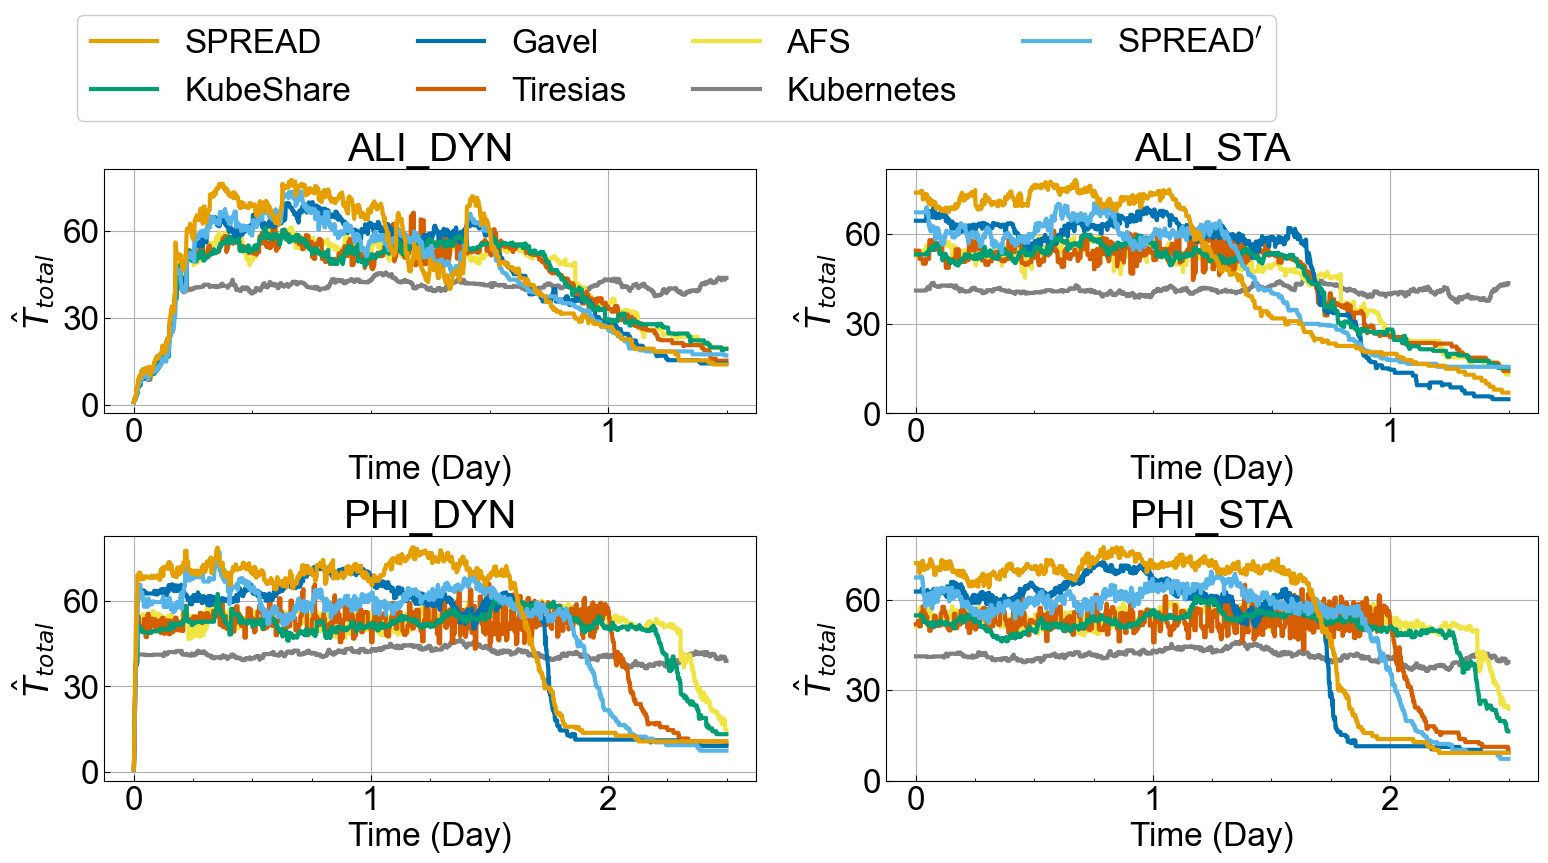

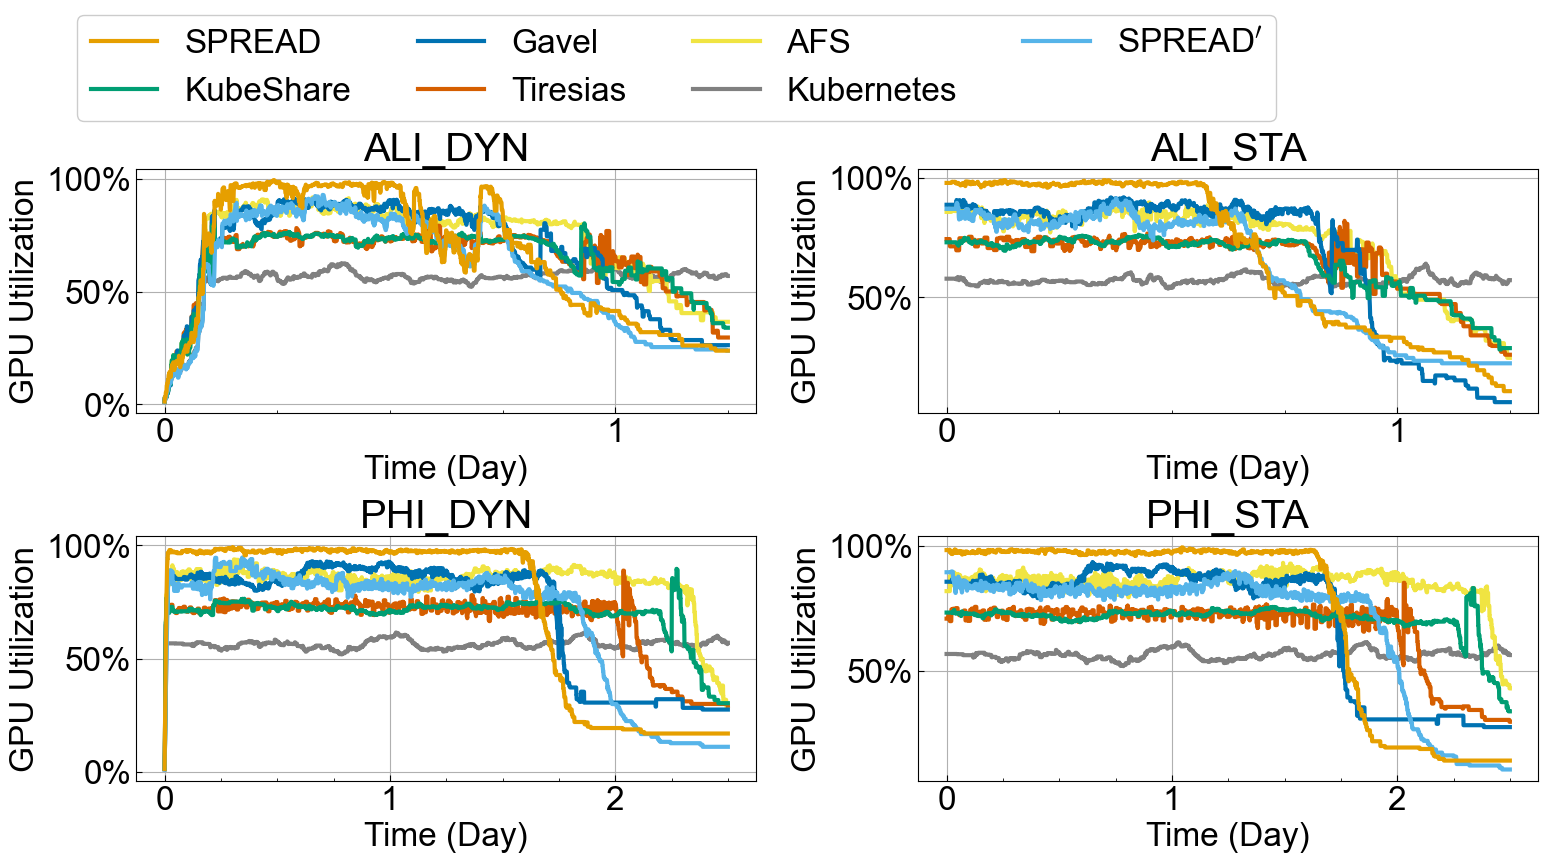

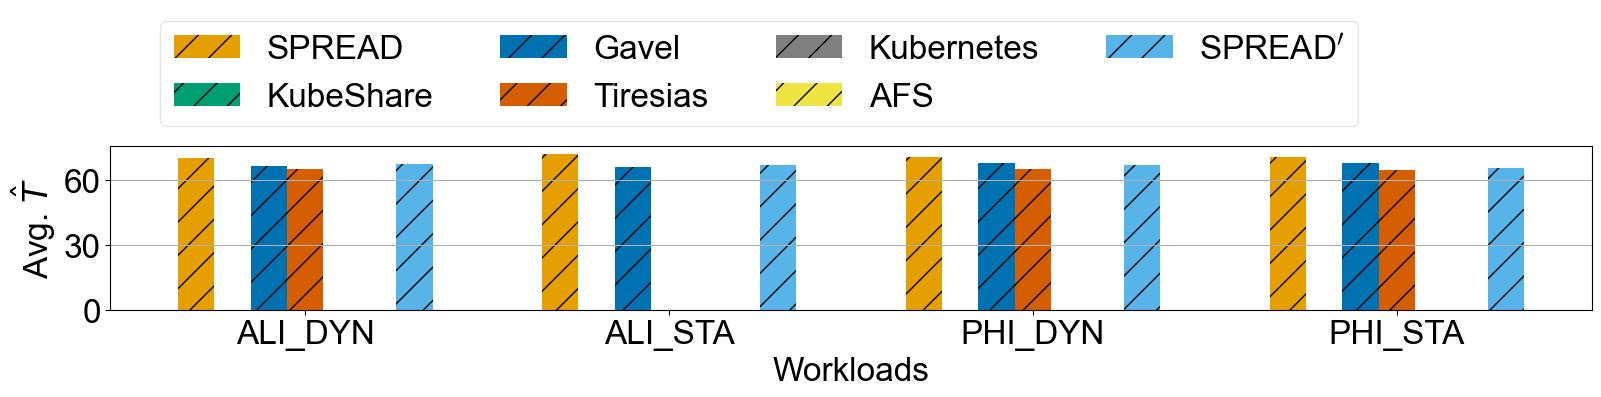

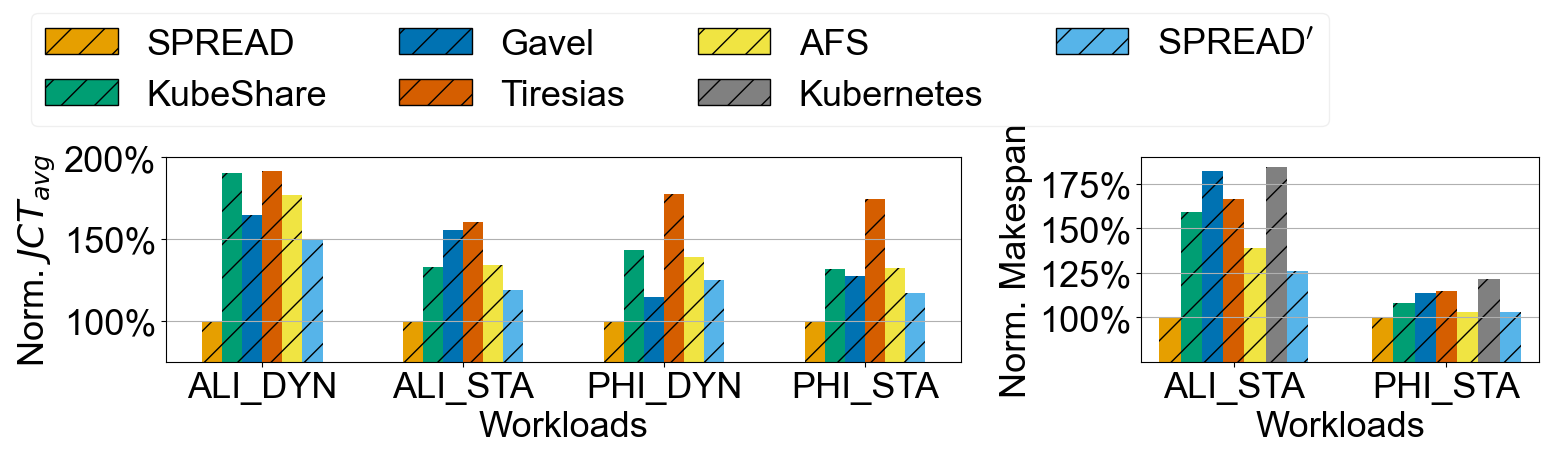

In [4]:
if LOAD_UTIL_CONFIG.LOAD_UTIL:
    plot_time_series_items_for_all_records()
    # plot_avg_time_series_profit_bar()
# plot_makespan_bar()
# plot_JCT_bar()
plot_JCT_and_makespan_bar()